In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

In [ ]:
!ls gdrive/MyDrive/data_image

california_wildfires  hurricane_irma   iraq_iran_earthquake  srilanka_floods
hurricane_harvey      hurricane_maria  mexico_earthquake


In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import transformers
from transformers import get_linear_schedule_with_warmup
from torchvision import transforms
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/Models/train.tsv", sep='\t')
df_train = df_train[['image', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/Models/val.tsv", sep='\t')
df_val = df_val[['image', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test.tsv", sep='\t')
df_test = df_test[['image', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [3]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, paths, targets):
    self.paths = paths
    self.targets = targets
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, item):
    path = str(self.paths[item])
    target = self.targets[item]

    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    return {
      'tweet_image': img,
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    paths=df.image.to_numpy(),
    targets=df.label_text.to_numpy(),
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.vgg = torchvision.models.vgg16(pretrained=True)
    # for param in self.vgg.parameters():
    #   param.requires_grad = False

    # self.linear1 = nn.Linear(1000, 256)
    # self.relu    = nn.ReLU()
    # self.dropout = nn.Dropout(p=0.4)
    # self.linear2 = nn.Linear(256, 1)
    self.linear = nn.Linear(1000, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, tweet_img):
    output = self.vgg(tweet_img)
    # linear1_output = self.linear1(output)
    # relu_output = self.relu(linear1_output)
    # dropout_output = self.dropout(relu_output)
    # linear2_output = self.linear2(dropout_output)
    # probas = self.sigmoid(linear2_output)

    linear_output = self.linear(output)
    probas = self.sigmoid(linear_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [4]:
BATCH_SIZE = 128

train_data_loader = create_data_loader(df_train, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 40

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

Epoch 1/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.437845589298951 accuracy 0.7946047286740964
Val   loss 0.37855299848776597 accuracy 0.8251748251748252

Epoch 2/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.27331077286285826 accuracy 0.8809499010519737
Val   loss 0.37337011328110326 accuracy 0.8302606484424666

Epoch 3/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16016215321310243 accuracy 0.9333402770544734
Val   loss 0.4568040989912473 accuracy 0.8239033693579149

Epoch 4/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0875329089988219 accuracy 0.964066243099677
Val   loss 0.56482388652288 accuracy 0.8270820089001907

Epoch 5/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.06856929182418083 accuracy 0.9706280595771274
Val   loss 0.683548051577348 accuracy 0.8372536554354736

Epoch 6/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.04652220062837985 accuracy 0.9816685761899802
Val   loss 0.7595583383853619 accuracy 0.8264462809917356

Epoch 7/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.04309998784600267 accuracy 0.9826059785439016
Val   loss 0.7668388761006869 accuracy 0.8251748251748252

Epoch 8/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.029536538591951524 accuracy 0.9876054577648161
Val   loss 0.9932226974230546 accuracy 0.8391608391608392

Epoch 9/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.02888537758324099 accuracy 0.9904176648265806
Val   loss 1.0280222846911504 accuracy 0.8188175460902734

Epoch 10/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.027469283657601887 accuracy 0.9902093531923758
Val   loss 1.0661499454424932 accuracy 0.810553083280356

Epoch 11/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.025156496122546838 accuracy 0.9906259764607853
Val   loss 1.0159716606140137 accuracy 0.8111888111888113

Epoch 12/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.015418726801726734 accuracy 0.9946880533277783
Val   loss 1.1712627640137305 accuracy 0.8283534647171011

Epoch 13/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0093541583389053 accuracy 0.9971877929382356
Val   loss 1.2160707666323736 accuracy 0.8251748251748252

Epoch 14/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.008556880530082517 accuracy 0.9979168836579523
Val   loss 1.361337382059831 accuracy 0.8302606484424666

Epoch 15/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.007313809921183029 accuracy 0.9978127278408498
Val   loss 1.2797598151060252 accuracy 0.8219961856325493

Epoch 16/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.003943404377950125 accuracy 0.9983335069263618
Val   loss 1.6141118498948903 accuracy 0.8270820089001907

Epoch 17/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.004037375692453344 accuracy 0.9982293511092594
Val   loss 1.5867379720394428 accuracy 0.8321678321678322

Epoch 18/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0035020161683764614 accuracy 0.9985418185605666
Val   loss 1.5489393289272602 accuracy 0.8302606484424666

Epoch 19/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.002894534734495162 accuracy 0.9985418185605666
Val   loss 1.3224701377061696 accuracy 0.8270820089001907

Epoch 20/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0018598916443639418 accuracy 0.9990625976460785
Val   loss 1.607399514088264 accuracy 0.8340750158931978

Epoch 21/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.001714800110840698 accuracy 0.9991667534631808
Val   loss 1.5869275423196645 accuracy 0.8321678321678322

Epoch 22/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0015155786043602635 accuracy 0.9991667534631808
Val   loss 1.7219022237337553 accuracy 0.8296249205340115

Epoch 23/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0015048246459029638 accuracy 0.9990625976460785
Val   loss 2.2462342977523804 accuracy 0.8334392879847425

Epoch 24/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0013364492689573269 accuracy 0.9993750650973856
Val   loss 2.101997292958773 accuracy 0.8302606484424666

Epoch 25/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0016099697915861772 accuracy 0.999479220914488
Val   loss 2.3876139108951273 accuracy 0.8347107438016529

Epoch 26/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.001103358251743645 accuracy 0.999479220914488
Val   loss 2.1138739585876465 accuracy 0.8334392879847425

Epoch 27/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.000973472424020297 accuracy 0.9993750650973856
Val   loss 2.7623496514100294 accuracy 0.8289891926255563

Epoch 28/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0009832958941848645 accuracy 0.9993750650973856
Val   loss 1.9562490857564485 accuracy 0.8296249205340115

Epoch 29/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006602722176909849 accuracy 0.9997916883657952
Val   loss 2.7355210322600145 accuracy 0.8302606484424666

Epoch 30/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0009307437409383487 accuracy 0.9995833767315905
Val   loss 2.73296234699396 accuracy 0.8302606484424666

Epoch 31/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006405422234126347 accuracy 0.9997916883657952
Val   loss 2.7221677761811476 accuracy 0.8340750158931978

Epoch 32/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0005732273792474237 accuracy 0.9997916883657952
Val   loss 2.781761105243976 accuracy 0.8340750158931978

Epoch 33/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0005187492083872545 accuracy 0.9996875325486928
Val   loss 2.845486274132362 accuracy 0.8328035600762873

Epoch 34/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006979206978718665 accuracy 0.9996875325486928
Val   loss 2.678099884436681 accuracy 0.8289891926255563

Epoch 35/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0005993279175234085 accuracy 0.9997916883657952
Val   loss 2.6825066667336683 accuracy 0.8296249205340115

Epoch 36/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0007687518931453795 accuracy 0.999479220914488
Val   loss 2.7464685027415934 accuracy 0.8359821996185632

Epoch 37/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006178899856157733 accuracy 0.9995833767315905
Val   loss 2.6821346237109256 accuracy 0.8308963763509218

Epoch 38/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0005609337364480899 accuracy 0.9995833767315905
Val   loss 2.623068717809824 accuracy 0.8296249205340115

Epoch 39/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0005187783937057439 accuracy 0.9995833767315905
Val   loss 2.6755780623509335 accuracy 0.831532104259377

Epoch 40/40
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0006005083831349854 accuracy 0.9995833767315905
Val   loss 2.678024273652297 accuracy 0.8302606484424666



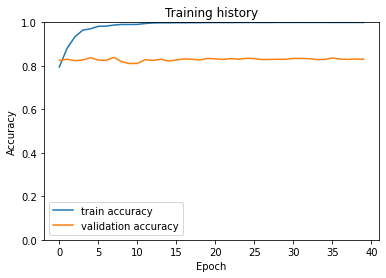

In [5]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

checkpoint = torch.load("./gdrive/MyDrive/Models/VGG/checkpoint.t7")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']

print(start_epoch)


# for epoch in range(EPOCHS):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,    
#     loss_fn, 
#     optimizer, 
#     device, 
#     scheduler, 
#     len(df_train)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn, 
#     device, 
#     len(df_val)
#   )

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if val_acc > best_accuracy:
#     state = {
#             'best_accuracy': val_acc,
#             'epoch': start_epoch+epoch+1,
#             'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict(),
#     }
#     savepath= "./gdrive/MyDrive/Models/VGG/checkpoint.t7"
#     torch.save(state,savepath)
#     best_accuracy = val_acc


In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/VGG/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

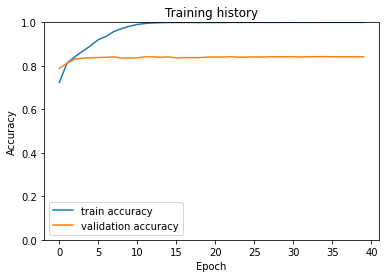

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(tweet_img=tweet_imgs)
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative'], digits=4))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative     0.7794    0.7500    0.7644       504
    Informative     0.8799    0.8961    0.8879      1030

       accuracy                         0.8481      1534
      macro avg     0.8296    0.8231    0.8262      1534
   weighted avg     0.8469    0.8481    0.8473      1534

